Using device: cpu


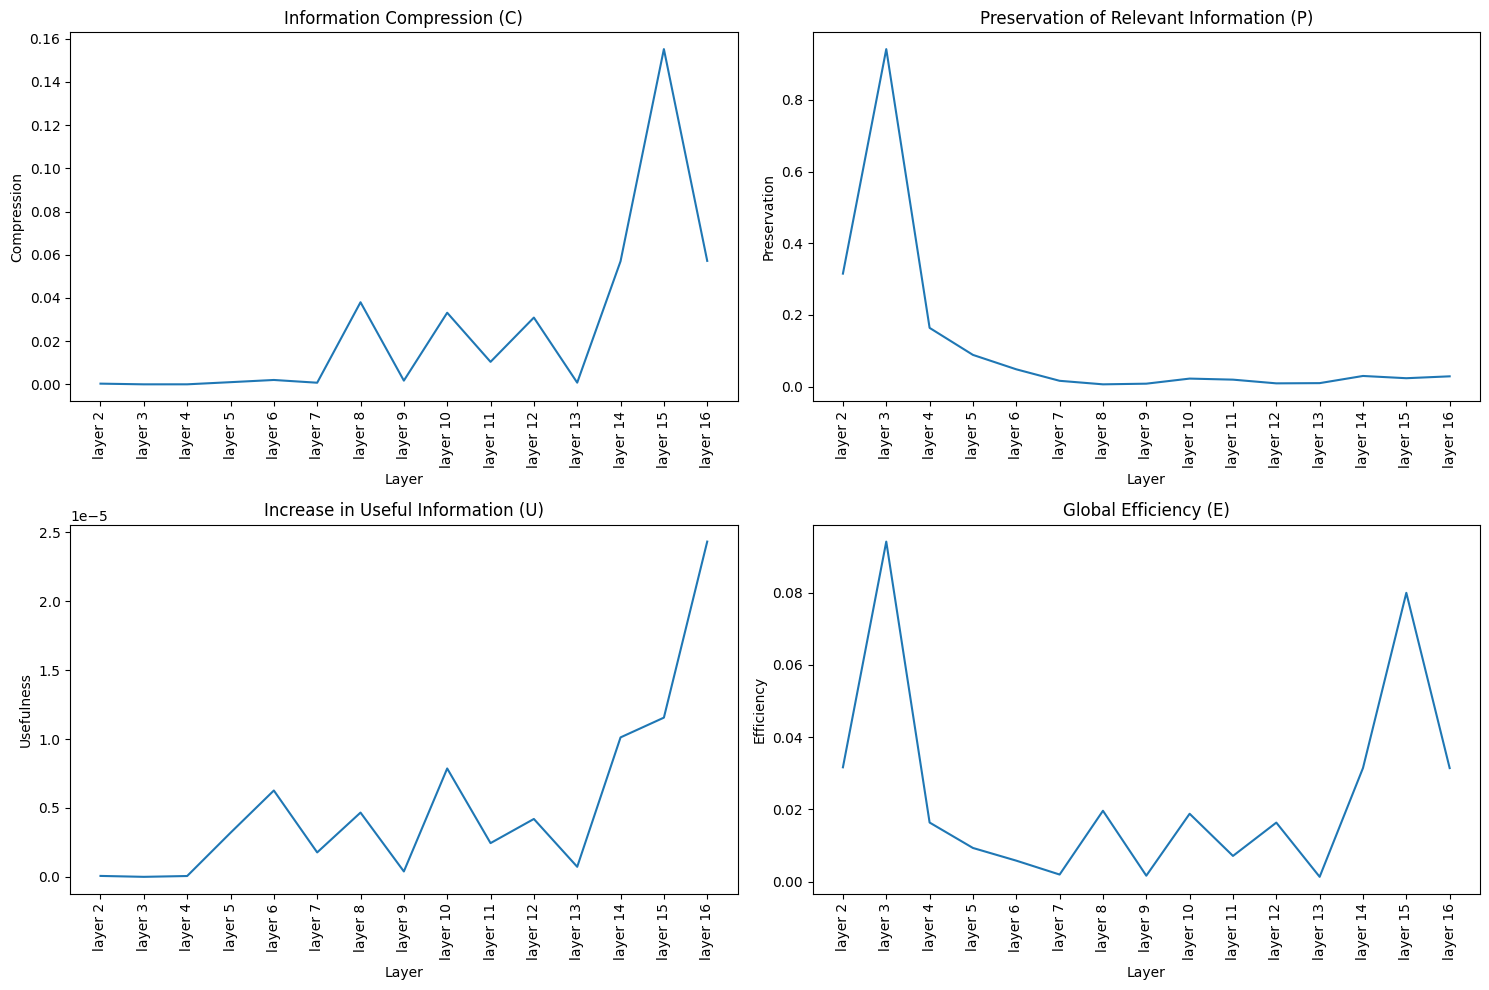

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import entropy
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNet50 model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
model.eval()

# Custom ILSVRC2017Dataset class
class ILSVRC2017Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_files.append(os.path.join(root, file))
                    self.labels.append(os.path.basename(os.path.dirname(os.path.join(root, file))))
        self.label_to_idx = {label: idx for idx, label in enumerate(set(self.labels))}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.label_to_idx[self.labels[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define data transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load ILSVRC2017 dataset
dataset = ILSVRC2017Dataset(root_dir="../data", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Select random samples
num_samples = 1000
random_samples = []
random_labels = []
for i, (image, label) in enumerate(dataloader):
    if i >= num_samples:
        break
    random_samples.append(image.to(device))
    random_labels.append(label.item())

# Define the layers to analyze
layer_modules = [
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool,
    model.layer1[0].conv1,
    model.layer1[1].conv1,
    model.layer1[2].conv1,
    model.layer2[0].conv1,
    model.layer2[1].conv1,
    model.layer2[2].conv1,
    model.layer2[3].conv1,
    model.layer3[0].conv1,
    model.layer3[2].conv1,
    model.layer3[5].conv1,
    model.layer4[2].conv1,
    model.fc
]
layer_names = [
    "layer 1",
    "layer 2",
    "layer 3",
    "layer 4",
    "layer 5",
    "layer 6",
    "layer 7",
    "layer 8",
    "layer 9",
    "layer 10",
    "layer 11",
    "layer 12",
    "layer 13",
    "layer 14",
    "layer 15",
    "layer 16"
]

# Function to calculate entropy
def calculate_entropy(activations):
    activations = activations.flatten()  # Flatten the activations
    hist, bin_edges = np.histogram(activations.cpu().numpy(), bins=256, density=True)
    prob_dist = hist / np.sum(hist)
    return entropy(prob_dist)

# Function to resample a tensor
def resample_tensor(tensor, new_size):
    x = np.arange(len(tensor))
    f = interp1d(x, tensor.cpu().numpy(), kind='linear')
    x_new = np.linspace(0, len(tensor) - 1, new_size)
    resampled_tensor = f(x_new)
    return torch.tensor(resampled_tensor)

# Function to compute mutual information
def mutual_information(x, y, num_bins=200):
    x = x.cpu().numpy() if isinstance(x, torch.Tensor) else x
    y = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

    x = x.flatten()
    y = y.flatten()
    if len(x) != len(y):
        max_len = max(len(x), len(y))
        x = resample_tensor(torch.tensor(x), max_len).numpy()
        y = resample_tensor(torch.tensor(y), max_len).numpy()
    joint_hist, x_edges, y_edges = np.histogram2d(x, y, bins=num_bins)

    x_hist = np.histogram(x, bins=x_edges)[0]
    y_hist = np.histogram(y, bins=y_edges)[0]

    p_xy = joint_hist / joint_hist.sum()
    p_x = x_hist / x_hist.sum()
    p_y = y_hist / y_hist.sum()

    p_xy = p_xy + 1e-9
    p_x = p_x + 1e-9
    p_y = p_y + 1e-9

    mi = np.sum(p_xy * (np.log(p_xy) - np.log(p_x[:, None]) - np.log(p_y[None, :])))

    return max(0, mi)

# Store activations of each layer
activations = {}
def hook_fn(module, input, output):
    activations[module] = output

# Attach hooks to selected layers
for layer in layer_modules:
    layer.register_forward_hook(hook_fn)

# Calculate metrics for each layer
compression = []
preservation = []
usefulness = []
efficiency = []
alpha = 0.5
beta = 0.1
gamma = 0.4

with torch.no_grad():
    for sample, label in zip(random_samples, random_labels):
        _ = model(sample)

        prev_entropy = None
        prev_activations = None

        layer_compression = []
        layer_preservation = []
        layer_usefulness = []
        layer_efficiency = []

        for i, layer in enumerate(layer_modules):
            current_activations = activations[layer]

            # Ensure activations are in the correct shape

            current_entropy = calculate_entropy(current_activations)

            if prev_entropy is not None:
                # Information Compression
                delta_H = current_entropy - prev_entropy
                C = max(0, -delta_H / prev_entropy)
                layer_compression.append(C)

                # Preservation of Relevant Information
                I_AlAl1 = mutual_information(prev_activations, current_activations)
                P = I_AlAl1 / min(prev_entropy, current_entropy)
                layer_preservation.append(P)

                # Increase in Useful Information
                I_TlY = mutual_information(current_activations, torch.tensor([label]).repeat(current_activations.size(0)))
                I_Tl1Y = mutual_information(prev_activations, torch.tensor([label]).repeat(prev_activations.size(0)))
                H_Y = entropy(np.bincount(random_labels) / len(random_labels))  # Entropy of labels
                U = max(0, (I_TlY - I_Tl1Y) / (H_Y - I_Tl1Y))
                layer_usefulness.append(U)

                # Global Efficiency
                E = alpha * C + beta * P + gamma * U
                layer_efficiency.append(E)

            prev_entropy = current_entropy
            prev_activations = current_activations

        compression.append(layer_compression)
        preservation.append(layer_preservation)
        usefulness.append(layer_usefulness)
        efficiency.append(layer_efficiency)

# Average the metrics across samples
compression = np.mean(compression, axis=0)
preservation = np.mean(preservation, axis=0)
usefulness = np.mean(usefulness, axis=0)
efficiency = np.mean(efficiency, axis=0)

# Plot the curves
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(layer_names[1:], compression)
plt.title('Information Compression (C)')
plt.xlabel('Layer')
plt.ylabel('Compression')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
plt.plot(layer_names[1:], preservation)
plt.title('Preservation of Relevant Information (P)')
plt.xlabel('Layer')
plt.ylabel('Preservation')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
plt.plot(layer_names[1:], usefulness)
plt.title('Increase in Useful Information (U)')
plt.xlabel('Layer')
plt.ylabel('Usefulness')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
plt.plot(layer_names[1:], efficiency)
plt.title('Global Efficiency (E)')
plt.xlabel('Layer')
plt.ylabel('Efficiency')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
